In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from yahoofinancials import YahooFinancials

In [2]:
import bs4 as bs
import pickle
import requests

def save_sp500_tickers():
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
        pickle.dump(tickers,f)
        
    return tickers

#save_sp500_tickers()

In [3]:
def download_csv_data(ticker, start_date, end_date, freq, path):
    
    yahoo_financials = YahooFinancials(ticker)

    df = yahoo_financials.get_historical_price_data(start_date, end_date, freq)
    df = pd.DataFrame(df[ticker]['prices']).drop(['date'], axis=1) \
            .rename(columns={'formatted_date':'date'}) \
            .loc[:, ['date','open','high','low','close','volume']] \
            .set_index('date')
    df.index = pd.to_datetime(df.index)
    df['dividend'] = 0
    df['split'] = 1

    # save data to csv for later ingestion
    df.to_csv(path, header=True, index=True)

    # plot the time series
    df.close.plot(title='{} prices --- {}:{}'.format(ticker, start_date, end_date));

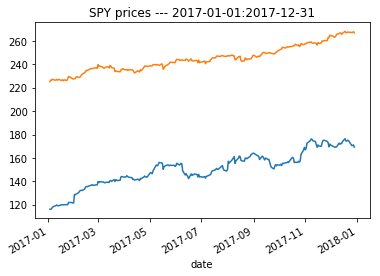

In [4]:
tickers=['AAPL', 'SPY']

for ticker in tickers:
    download_csv_data(ticker=ticker, 
                      start_date='2017-01-01', 
                      end_date='2017-12-31', 
                      freq='daily', 
                      path='european/daily/'+ticker.strip(' .^')+'.csv')
    df=None

In [5]:
from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities
import os

start_session = pd.Timestamp('2017-01-03', tz='utc')
end_session = pd.Timestamp('2017-12-29', tz='utc')

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(),'european')
# Create an ingest function 
ingest_func = csvdir_equities(['daily'], os.environ['ZIPLINE_ROOT'])

# Register the data bundle and its ingest function
bundles.register('eu_stocks', ingest_func, 
                 calendar_name='NYSE',  # Euronext Amsterdam
                start_session=start_session,
                end_session=end_session);

In [6]:
bundles.ingest('eu_stocks')


 | AAPL: sid 0
 | SPY: sid 1


In [7]:
bundle_data = bundles.load('eu_stocks')

### Algorithm

In [11]:
#: NOTICE HOW THIS IS OUTSIDE INITIALIZE, BECAUSE IT IS, WE CAN REDEFINE IT EVERYTIME WE REDINE INITIALIZE


from zipline.api import *
short_mavg_days = 20
long_mavg_days = 50

def initialize(context):
    context.aapl = symbol('AAPL')
    context.spy = symbol('SPY')
    
    # Set context parameters based on global parameters 
    context.short_mavg_days = short_mavg_days
    context.long_mavg_days = long_mavg_days
    
    # Register 2 histories that track daily prices,
    # one with a short window and one with a long window

    # Used to warm-up moving averages
    context.i = 0
    
def handle_data(context, data):
    
    # Skip days to get full windows
    context.i += 1
    if context.i < context.long_mavg_days:
        return
    
    # Compute averages
    # history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.aapl, 'price', bar_count=5, frequency="1d").mean()
    long_mavg = data.history(context.aapl, 'price', bar_count=10, frequency="1d").mean()

    #sym = symbol('AAPL')

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        #print(1)
        order_target_percent(context.aapl, 1)
    elif short_mavg < long_mavg:
        order_target_percent(context.aapl, 0)


In [12]:
from datetime import datetime
from trading_calendars import get_calendar
import pytz
import zipline
perf = zipline.run_algorithm(start=datetime(2017, 1, 2, 0 , 0, 0, 0, pytz.utc),
                      end=datetime(2017, 12, 29,0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      bundle='eu_stocks',
                      trading_calendar=get_calendar('NYSE'))
perf

/Users/cnakhare/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/cnakhare/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2017-01-02 16:30:00+00:00,NaN,0.000000,None,0.0,NaN,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,1,[],0.0
2017-01-03 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,2,[],0.0
2017-01-04 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,3,[],0.0
2017-01-05 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,4,[],0.0
2017-01-06 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,5,[],0.0
2017-01-09 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,6,[],0.0
2017-01-10 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,7,[],0.0
2017-01-11 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,8,[],0.0
2017-01-12 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,9,[],0.0
2017-01-13 16:30:00+00:00,0.000000,0.000000,None,0.0,0.0,None,0.000000,100000.000000,0.000,0.000,...,0.0,0.0,0,NaN,100000.000000,0.000,0.000,10,[],0.0


In [14]:
#: Get the sharpe ratio
sharpe = (perf.returns.mean()*252)/(perf.returns.std() * np.sqrt(252))
print("The Sharpe ratio is %0.6f" % sharpe)

The Sharpe ratio is 0.644302


In [33]:
from collections import defaultdict

# This will create a list with 9 entries
short_mavg_days_list = [days for days in np.arange(5, 50, 5)]
# This will create a list with 40 entries
long_mavg_days_list = [days for days in np.arange(10, 210, 5)]

#: Create a dictionary to hold all the results of our algorithm run
all_sharpes = defaultdict(dict)

# Count the number of backtests run
backtest_count = 0

# This will loop and run 324 backtests
# Each backtest takes about 3 seconds, so this will take around 16 minutes
for short_mavg_days in short_mavg_days_list:
    for long_mavg_days in long_mavg_days_list:
        # Only consider cases where the short is less than long.. but why this not working?
        if short_mavg_days < long_mavg_days:
            
            #: Redefine initialize with new weights
            def initialize(context):
                context.aapl = context.aapl = symbol('AAPL')
    
                # Set context parameters based on global parameters 
                context.short_mavg_days = short_mavg_days
                context.long_mavg_days = long_mavg_days
    

                # Used to warm-up moving averages
                context.i = 0  
      
            perf_manual = zipline.run_algorithm(start=datetime(2017, 1, 2, 0 , 0, 0, 0, pytz.utc),
                      end=datetime(2017, 12, 29,0, 0, 0, 0, pytz.utc),
                      initialize=initialize,
                      capital_base=100000,
                      handle_data=handle_data,
                      bundle='eu_stocks',
                      trading_calendar=get_calendar('NYSE'))
            
            # Keep track of how many backtests were run
            backtest_count += 1
            print("Backtest {0} completed..." + str(backtest_count))
            
            # Calculate the sharpe for this backtest
            sharpe = (perf_manual.returns.mean()*252)/(perf_manual.returns.std() * np.sqrt(252))
        
            #: Add the result to our dict
            all_sharpes[short_mavg_days][long_mavg_days] = sharpe


print()
print("All backtest simulations completed!")
print()

all_sharpes = pd.DataFrame(all_sharpes)
all_sharpes.index.name = "Long Moving Average Days"
all_sharpes.columns.name = "Short Moving Average Days"

/Users/cnakhare/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/Users/cnakhare/opt/anaconda3/envs/env_zipline/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


Backtest {0} completed...1
Backtest {0} completed...2
Backtest {0} completed...3
Backtest {0} completed...4
Backtest {0} completed...5
Backtest {0} completed...6
Backtest {0} completed...7
Backtest {0} completed...8
Backtest {0} completed...9
Backtest {0} completed...10
Backtest {0} completed...11
Backtest {0} completed...12
Backtest {0} completed...13
Backtest {0} completed...14
Backtest {0} completed...15
Backtest {0} completed...16
Backtest {0} completed...17
Backtest {0} completed...18
Backtest {0} completed...19
Backtest {0} completed...20
Backtest {0} completed...21
Backtest {0} completed...22
Backtest {0} completed...23
Backtest {0} completed...24
Backtest {0} completed...25
Backtest {0} completed...26
Backtest {0} completed...27
Backtest {0} completed...28
Backtest {0} completed...29
Backtest {0} completed...30
Backtest {0} completed...31
Backtest {0} completed...32
Backtest {0} completed...33
Backtest {0} completed...34
Backtest {0} completed...35
Backtest {0} completed...36
B

Backtest {0} completed...288
Backtest {0} completed...289
Backtest {0} completed...290
Backtest {0} completed...291
Backtest {0} completed...292
Backtest {0} completed...293
Backtest {0} completed...294
Backtest {0} completed...295
Backtest {0} completed...296
Backtest {0} completed...297
Backtest {0} completed...298
Backtest {0} completed...299
Backtest {0} completed...300
Backtest {0} completed...301
Backtest {0} completed...302
Backtest {0} completed...303
Backtest {0} completed...304
Backtest {0} completed...305
Backtest {0} completed...306
Backtest {0} completed...307
Backtest {0} completed...308
Backtest {0} completed...309
Backtest {0} completed...310
Backtest {0} completed...311
Backtest {0} completed...312
Backtest {0} completed...313
Backtest {0} completed...314
Backtest {0} completed...315
Backtest {0} completed...316
Backtest {0} completed...317
Backtest {0} completed...318
Backtest {0} completed...319
Backtest {0} completed...320
Backtest {0} completed...321
Backtest {0} c

Short Moving Average Days        5         10        15        20        25  \
Long Moving Average Days                                                      
10                         1.613037       NaN       NaN       NaN       NaN   
15                         1.518555  1.518555       NaN       NaN       NaN   
20                         1.249542  1.249542  1.249542       NaN       NaN   
25                         1.076450  1.076450  1.076450  1.076450       NaN   
30                         0.896998  0.896998  0.896998  0.896998  0.896998   
35                         0.845551  0.845551  0.845551  0.845551  0.845551   
40                         0.725157  0.725157  0.725157  0.725157  0.725157   
45                         0.741480  0.741480  0.741480  0.741480  0.741480   
50                         0.657126  0.657126  0.657126  0.657126  0.657126   
55                         0.615527  0.615527  0.615527  0.615527  0.615527   
60                         0.463359  0.463359  0.463

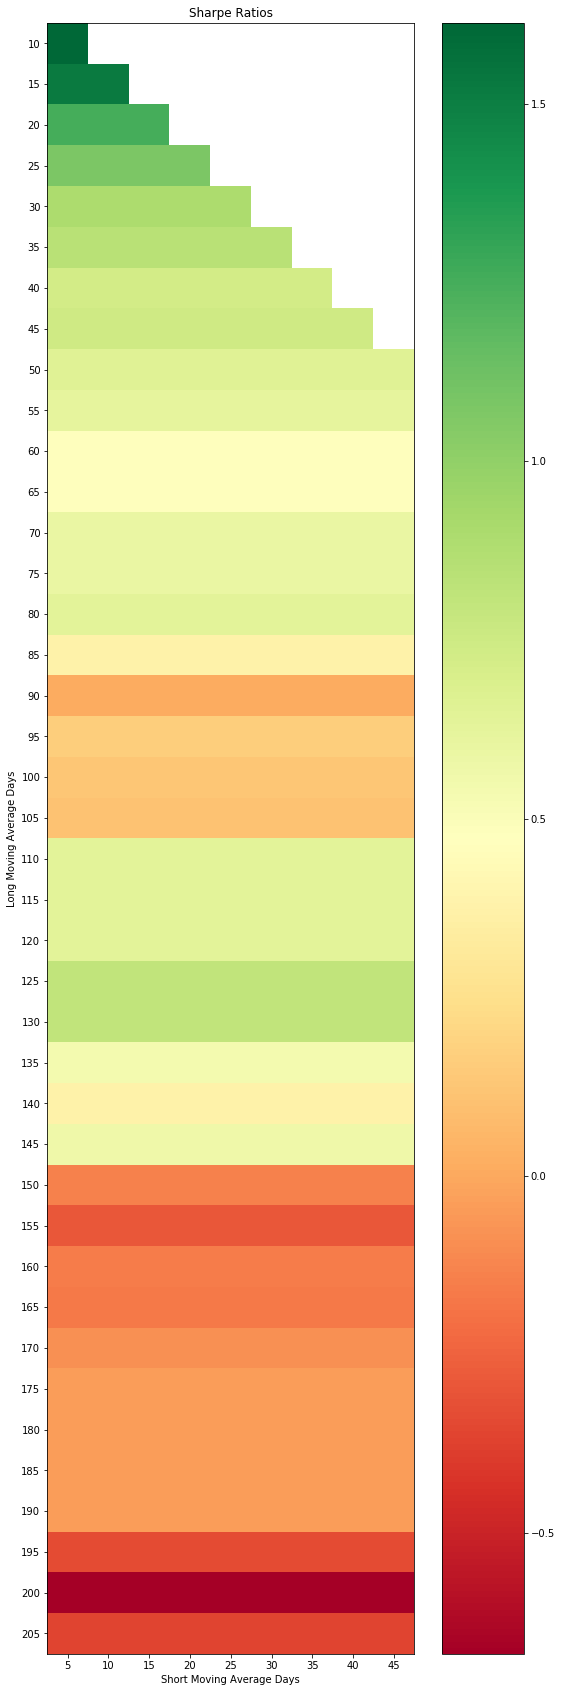

In [34]:
import matplotlib.pyplot as pyplot
%matplotlib inline


def heat_map(df):
    """
    This creates our heatmap using our sharpe ratio dataframe
    """
    fig = pyplot.figure(figsize=(10,30))
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values,cmap = pyplot.get_cmap('RdYlGn'), interpolation = 'nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    ax.set_title("Sharpe Ratios")
    pyplot.colorbar(axim)
    
#: Plot our heatmap
heat_map(all_sharpes)

print(all_sharpes)

In [35]:
Max_Sharpe = max(all_sharpes.max(axis=1))
print("Maximum Sharpe ="+ str(Max_Sharpe))

Maximum Sharpe =1.6130368893330056
